# 05 - 线性回归超乎寻常的有效性


## 你需要的只是回归

在处理因果推断时，我们看到每个人有两个潜在的结果：\\(Y_0\\) 是个体如果不接受干预的结果和 \\(Y_1\\)是他或她接受干预的结果。将干预变量 \\(T\\) 设置为 0 或 1 的行为会实现其中一个潜在结果，并使我们不可能知道另一个结果。这导致个体处理效果\\(\tau_i = Y_{1i} - Y_{0i}\\) 是不可知的。

$
Y_i = Y_{0i} + T_i(Y_{1i} - Y_{0i}) = Y_{0i}(1-T_i) + T_i Y_{1i}
$

所以，现在，让我们专注于估计平均因果效应这个更简单的任务。考虑到这一点，我们接受这样一个事实，即有些人对干预的反应比其他人更好，但我们也接受我们无法知道他们是谁的事实。相反，我们将尝试看看，**平均而言**，干预是否有效。

$
ATE = E[Y_1 - Y_0]
$

这将为我们提供一个简化的模型，具有固定的处理效果 \\(Y_{1i} = Y_{0i} + \kappa\\)。如果 \\(\kappa\\) 是正的，我们会说，平均而言，干预具有积极的效果。即使有些人会对此做出不良反应，但平均而言，其影响将是积极的。

大家应该还记得，由于偏差的存在，我们不能简单地用平均值的差异 \\(E[Y|T=1] - E[Y|T=0]\\)来估计 \\(E[Y_1 - Y_0]\\) 。当受干预与否的两方也受到干预本身以外的因素影响时，往往会出现偏差。下面对它们在潜在结果方面的差异 \\(Y_0\\)的拆解可以看到偏差的影响：

$
E[Y|T=1] - E[Y|T=0] = \underbrace{E[Y_1 - Y_0|T=1]}_{ATET} + \underbrace{\{ E[Y_0|T=1] - E[Y_0|T=0]\}}_{BIAS}
$

之前，我们看到了如何通过随机实验，也被称为 **随机对照试验** (RCT)，的方法来消除偏差。 RCT 迫使接受干预的和未接受干预的人统计上一样，从而消除偏差的影响。我们还看到了如何在我们对干预效果的估计值上设置不确定性水平。也就是说，我们研究了在线教学与面对面教学的情况，其中 \\(T=0\\) 代表面对面授课，\\(T=1\\) 代表在线课堂。学生被随机分配到这两种类型的讲座中的一种，然后评估他们在考试中的表现。我们已经建立了一个 A/B 测试函数，可以对两组人群进行比较，并提供平均干预效果的估计值，并为其提供一个置信区间。

现在，我们可以看看如何使用因果推理的主要工具，**线性回归**，来完成上述这些工作！这么想吧。如果把比较处理过和未处理过的平均值比作甜点里的苹果，那么线性回归就是甜点里的冷奶油提拉米苏。或者，如果直接比较干预和未干预对象的方法像是一条陈年老式的白麦面包，那么线性回归将是由酸面团制作，并由查德·罗伯逊本人亲自烘焙而成的外脆内软的乡村风格面包，好吃的不得了。

![img](./data/img/linear-regression/you_vs.png)

让我们看看这种美是如何运作的。在下面的代码中，我们希望将上述线课程与面对面课程的效能比较进行完全相同的分析。但是，与其进行获得置信区间所需的复杂数学运算，我们直接进行回归分析。更具体地说，我们估计以下模型：

$
EXAM_i = \beta_0 + \kappa \ Online_i + u_i
$

请注意，\\(Online\\) 指代干预与否的，因此是一个虚拟变量。当面对面教学时，干预变量值为 0，在线时则为 1。考虑到这一点，我们可以看到通过线性回归将得到 \\(E[Y|T=0] = \beta_0\\) 和 \\(E[Y|T=1] = \beta_0 + \kappa \\)。其中 \\(\kappa\\) 将是我们的 ATE。

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
%matplotlib inline

data = pd.read_csv("data/online_classroom.csv").query("format_blended==0")
result = smf.ols('falsexam ~ format_ol', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.5475,1.113,70.563,0.000,76.353,80.742
format_ol,-4.9122,1.680,-2.925,0.004,-8.223,-1.601


这个方法确实相当惊人。 我们不仅能够估计 ATE，而且还可以毫不费力地获得置信区间和 P 值！ 更重要的是，我们可以看到回归方法做得正是我们希望它做得事情：比较 \\(E[Y|T=0]\\) 和 \\(E[Y|T=1]\\)。 截距正是\\(T=0\\),\\(E[Y|T=0]\\)时的样本均值，是否在线授课变量对应的系数正是均值的样本差值\\( E[Y|T=1] - E[Y|T=0]\\)。 还不相信？ 没问题。 你可以亲眼看看：

In [2]:
(data
 .groupby("format_ol")
 ["falsexam"]
 .mean())

format_ol
0    78.547485
1    73.635263
Name: falsexam, dtype: float64

正如预期的那样。如果在截距中加入ATE，即是否在线授课变量的参数估计，则得到处理后的样本均值：\\(78.5475 + (-4.9122) = 73.635263\\)。

## 回归理论

我不打算深入研究线性回归是如何构建和估计的。然而，一点点理论将有助于解释它在因果推断中的力量。首先，回归解决了理论上的最佳线性预测问题。令 \\(\beta^*\\) 是一个参数向量：

$
\beta^* =\underset{\beta}{argmin} \ E[(Y_i - X_i'\beta)^2]
$

线性回归找到最小化均方误差 (**M**ean **S**quared **E**rror，MSE) 的参数。

如果你对上述等式进行微分并将其置零，你会发现这个问题的线性解由下式给出

$
\beta^* = E[X_i'X_i]^{-1}E[X_i' Y_i]
$

面对样本估计的时候，我们可以使用等价如下公式估计这个 beta：

$
\hat{\beta} = (X'X)^{-1}X' Y
$

但不要只看上面的论述。如果相对钻研公式，您更喜欢直接写代码，那么不妨自己尝试一下：

In [3]:
X = data[["format_ol"]].assign(intercep=1)
y = data["falsexam"]

def regress(y, X): 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([-4.9122215 , 78.54748458])

上面的公式很笼统。 然而，我们研究只有一个回归变量的情况是值得的。 在因果推断中，我们经常想估计变量 \\(T\\) 对结果 \\(y\\) 的因果影响。 因此，我们使用带有这个单一变量的回归来估计这种影响。 即使我们在模型中包含其他变量，它们通常也只是辅助变量。 添加其他变量可以帮助我们估计干预的因果效应，但我们对估计它们的参数不是很感兴趣。

对于单个回归变量 \\(T\\)，与其关联的参数将由下式给出

$
\beta_1 = \dfrac{Cov(Y_i, T_i)}{Var(T_i)}
$

如果 \\(T\\) 是随机分配的，则 \\(\beta_1\\) 是 ATE。

In [4]:
kapa = data["falsexam"].cov(data["format_ol"]) / data["format_ol"].var()
kapa

-4.912221498226954

如果我们有多个回归量，我们可以扩展以下公式来适应这一点。假设那些其他变量只是辅助变量，我们真正感兴趣的只是估计与 \\(T\\) 关联的参数 \\(\kappa\\)。

$
y_i = \beta_0 + \kappa T_i + \beta_1 X_{1i} + ... +\beta_k X_{ki} + u_i
$

\\(\kappa\\) 可以通过以下公式获得

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})}
$

其中 \\(\tilde{T_i}\\) 是所有其他协变量 \\(X_{1i} + ... + X_{ki}\\) 在 \\(T_i\\) 上回归的残差。现在，让我们欣赏一下这有多酷。这意味着多元回归的系数是在考虑模型中其他变量的影响后**相同回归量的双变量系数**。在因果推断方面，\\(\kappa\\) 是 \\(T\\) 在使用所有其他变量进行预测后的双变量系数。

这背后有一个很好的直觉解释。如果我们可以使用其他变量来预测 \\(T\\)，那就意味着它不是随机的。但是，一旦我们控制了其他可用变量，我们就可以使 \\(T\\) 与随机一样好。为此，我们使用线性回归从其他变量预测它，然后我们取该回归的残差 \\(\tilde{T}\\)。根据定义，\\(\tilde{T}\\) 不能被我们已经用来预测 \\(T\\) 的其他变量 \\(X\\) 预测。非常优雅地，\\(\tilde{T}\\) 是一种与\\(X\\) 中的任何其他变量无关的处理版本。

顺便说一下，这也是线性回归的一个特性。残差始终与创建它的模型中的任何变量正交或不相关：

In [5]:
e = y - X.dot(beta)
print("正交意味着矩阵相乘结果为0", np.dot(e, X))
X[["format_ol"]].assign(e=e).corr()

正交意味着矩阵相乘结果为0 [-5.18696197e-13  1.64135372e-12]


,format_ol,e
format_ol,1.000000e+00,-9.653303e-16
e,-9.653303e-16,1.000000e+00


更酷的是，这些属性不依赖于任何东西！无论您的数据是什么样子，它们都是数学真理。

## 非随机数据的回归

到目前为止，我们使用的是随机实验数据，但正如我们所知，这些数据很难获得。进行实验的成本非常高，或者根本不可行。很难说服麦肯锡公司随机免费提供他们的服务，以便我们能够一劳永逸地将他们的咨询服务带来的价值与那些有能力支付他们的公司已经很好的事实区分开来离开。


出于这个原因，我们现在将深入研究非随机或观察数据。在以下示例中，我们将尝试估计多受教育一年对小时工资的影响。正如您可能已经猜到的那样，进行教育实验是极其困难的。你不能简单地将人们随机分配到 4、8 或 12 年的教育中。在这种情况下，我们只有观察数据。

首先，让我们估计一个非常简单的模型。我们将对受教育年限的小时工资进行回归。我们在这里使用对数，以便我们的参数估计有一个百分比解释。有了它，我们就可以说多接受 1 年的教育会使工资增加 x%。

$
日志（hwage）_i = \beta_0 + \beta_1 edu_i + u_i
$

In [17]:
wage = pd.read_csv("./data/wage.csv").dropna()
model_1 = smf.ols('np.log(hwage) ~ educ', data=wage.assign(hwage=wage["wage"]/wage["hours"])).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.104,22.089,0.000,2.102,2.512
educ,0.0536,0.008,7.114,0.000,0.039,0.068


\\(\beta_1\\) 的估计值为 0.0536，95% 的置信区间为 (0.039, 0.068)。 这意味着该模型预测，每增加一年的教育，工资将增加约 5.3%。 这一百分比增长符合教育以指数方式影响工资的信念：我们预计从 11 年到 12 年的教育（平均到高中毕业）比从 14 到 16 年（平均到毕业 大学）。

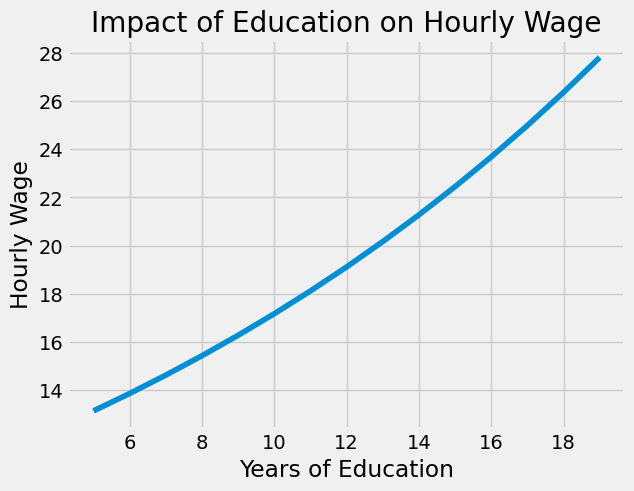

In [7]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

x = np.array(range(5, 20))
plt.plot(x, np.exp(model_1.params["Intercept"] + model_1.params["educ"] * x))
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage")
plt.title("Impact of Education on Hourly Wage")
plt.show()

当然，并不是因为我们可以估计这个简单的模型是正确的。请注意我是如何小心地用我的话来**预测**来自教育的工资。我从来没有说过这个预测是因果关系。事实上，到现在为止，您可能有非常严重的理由相信这个模型是有偏见的。由于我们的数据并非来自随机实验，因此我们不知道受教育程度高的人和受教育程度低的人是否具有可比性。更进一步，根据我们对世界运作方式的理解，我们非常确定它们没有可比性。也就是说，我们可以争辩说，那些受教育年限更长的人可能拥有更富裕的父母，而且随着教育程度的提高，我们看到的工资增长只是家庭财富与受教育年限的关系的反映。用数学来说，我们认为\\(E[Y_0|T=0] < E[Y_0|T=1]\\)，也就是说，那些受教育程度高的人无论如何都会有更高的收入，即使没有这么多年的教育。如果你对教育真的很冷淡，你可以争辩说它甚至可以通过让人们远离劳动力和降低他们的经验来*减少*工资。

幸运的是，在我们的数据中，我们可以访问许多其他变量。我们可以看到父母的教育‘meduc’、‘feduc’、那个人的‘IQ’分数、经验年数‘exper’以及他或她在当前公司的任期‘tenure’。我们甚至有一些关于婚姻和黑人种族的虚拟变量。

In [8]:
wage.head()

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0
6,600,40,2.708050,91,10,13,0,30,0,0,0,1,1,2.0,8.0,8.0


我们可以在模型中包含所有这些额外变量并对其进行估计：

$
log(hwage)_i = \beta_0 + \kappa \ educ_i + \pmb{\beta}X_i + u_i
$

要了解这如何帮助解决偏差问题，让我们回顾一下多元线性回归的二元细分。

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})}
$

这个公式说我们可以根据父母的教育、智商、经验等来预测“edu”。在我们这样做之后，我们将得到一个版本的 `edu`，\\(\tilde{edu}\\)，它与之前包含的所有变量都不相关。这将打破诸如“受过更多教育年限的人因为他们的智商更高而拥有它。教育不会导致更高的工资的情况。只是与智商相关的情况，这就是推动工资”。好吧，如果我们在我们的模型中包含 IQ，那么 \\(\kappa\\) 将成为额外一年教育的回报，同时保持 IQ 不变。暂停一下以了解这意味着什么。即使我们不能使用随机对照试验来保持治疗和未治疗之间的其他因素相等，回归可以通过在模型中包含这些相同的因素来做到这一点，即使数据不是随机的！

In [9]:
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

X = wage[controls].assign(intercep=1)
t = wage["educ"]
y = wage["lhwage"]

beta_aux = regress(t, X)
t_tilde = t - X.dot(beta_aux)

kappa = t_tilde.cov(y) / t_tilde.var()
kappa

0.04114719101006357

我们刚刚估计的这个系数告诉我们，对于具有相同智商、经验、任期、年龄等的人，我们应该预期多受教育一年与每小时工资增长 4.11% 相关。 这证实了我们的怀疑，即第一个只有 `edu` 的简单模型是有偏见的。 它还证实，这种偏见高估了教育的影响。 一旦我们控制了其他因素，教育的估计影响就会下降。

如果我们更聪明并使用其他人编写的软件而不是自己编写所有代码，我们甚至可以在这个估计值周围放置一个置信区间。

In [10]:
model_2 = smf.ols('lhwage ~ educ +' + '+'.join(controls), data=wage).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1156,0.232,4.802,0.000,0.659,1.572
educ,0.0411,0.010,4.075,0.000,0.021,0.061
IQ,0.0038,0.001,2.794,0.005,0.001,0.006
exper,0.0153,0.005,3.032,0.003,0.005,0.025
tenure,0.0094,0.003,2.836,0.005,0.003,0.016
age,0.0086,0.006,1.364,0.173,-0.004,0.021
married,0.1795,0.053,3.415,0.001,0.076,0.283
black,-0.0801,0.063,-1.263,0.207,-0.205,0.044
south,-0.0397,0.035,-1.129,0.259,-0.109,0.029
urban,0.1926,0.036,5.418,0.000,0.123,0.262


## 省略变量或混淆偏差

剩下的问题是：我们估计的这个参数是因果关系吗？不幸的是，我们不能肯定地说。我们可以争辩说，第一个回归教育工资的简单模型可能不是。它忽略了与教育和工资相关的重要变量。在不控制它们的情况下，教育的估计影响也会捕捉未包含在模型中的其他变量的影响。

为了更好地理解这种偏见是如何运作的，让我们假设教育如何影响工资的真实模型看起来有点像这样

$
工资_i = \alpha + \kappa \ Educ_i + A_i'\beta + u_i
$

工资受教育的影响，它由 \\(\kappa\\) 的大小和其他能力因素来衡量，表示为向量 \\(A\\)。如果我们从模型中省略了能力，我们对 \\(\kappa\\) 的估计将如下所示：

$
\dfrac{Cov(Wage_i, Educ_i)}{Var(Educ_i)} = \kappa + \beta'\delta_{Ability}
$

其中 \\(\delta_{A}\\) 是 \\(A\\) 对 \\(Educ\\) 回归的系数向量

这里的关键是它不会是我们想要的 \\(\kappa\\)。相反，它带有这个额外烦人的术语 \\(\beta'\delta_{A}\\)。该术语是省略 \\(A\\) 对 \\(Wage\\) 的影响，\\(\beta\\) 乘以省略对包含的 \\(Educ\\) 的影响。约书亚·安格里斯特 (Joshua Angrist) 用它制作了一个咒语，这样学生们就可以在冥想中背诵它，这对经济学家来说很重要：

``
“短等于长
加上省略的效果
次回归省略对包括“
``

在这里，短回归是省略变量的回归，而长回归是包括变量的回归。这个公式或咒语让我们进一步了解偏见的本质。首先，如果省略的变量对因变量 \\(Y\\) 没有影响，则偏差项将为零。这完全有道理。当我试图了解教育对工资的影响时，我不需要控制与工资无关的东西（比如田野里的百合花有多高）。其次，如果省略的变量对处理变量没有影响，偏差项也将为零。这也具有直观意义。如果所有影响教育的因素都包含在模型中，则教育的估计影响不可能与教育对其他也会影响工资的事物的相关性混合在一起。

![img](data/img/linear-regression/confused_cat.png)

更简洁地说，我们说**如果模型中考虑了所有混杂变量，则没有 OVB**。我们也可以在这里利用我们关于因果图的知识。混杂变量是**导致治疗和结果**的变量。在工资示例中，IQ 是一个混杂因素。智商高的人往往完成更多年的教育，因为这对他们来说更容易，所以我们可以说智商导致了教育。智商高的人也往往更有生产力，因此工资更高，所以智商也会导致工资。由于混杂因素是影响治疗和结果的变量，我们用指向 T 和 Y 的箭头标记它们。在这里，我用 \\(W\\) 表示它们。我还用红色标记了正因果关系，用蓝色标记了负​​因果关系。

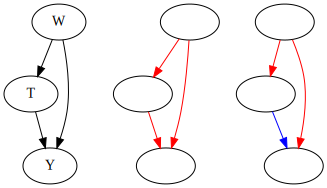

In [11]:
g = gr.Digraph()

g.edge("W", "T"), g.edge("W", "Y"), g.edge("T", "Y")

g.edge("智力", "教育", color="red"), g.edge("智力", "工资", color="red"), g.edge("教育", "工资", color="red")

g.edge("犯罪", "警察", color="red"), g.edge("犯罪", "暴力", color="red"), 
g.edge("警察", "暴力", color="blue")

g

因果图非常适合描绘我们对世界的理解并了解混淆偏差的工作原理。在我们的第一个例子中，我们有一个图表，其中教育导致工资：更多的教育导致更高的工资。然而，智商也会导致工资和教育：高智商会导致更多的教育和工资。如果我们在我们的模型中不考虑智商，它对工资的一些影响将通过与教育的相关性来体现。这将使教育的影响看起来比实际更高。这是正偏差的一个例子。

再举一个例子，但带有负面偏见，请考虑有关警察对城市暴力的影响的因果图。我们在世界上通常看到的是，警力高的城市也有更多的暴力。这是否意味着警察正在制造暴力？嗯，可能是，我认为不值得在这里进行讨论。但是，也很有可能存在一个混杂变量，导致我们看到警察对暴力影响的偏见版本。可能是增加警力减少暴力。但是，第三种可变犯罪会导致更多的暴力和更多的警察力量。如果我们不考虑它，犯罪对暴力的影响就会流经警察部队，使它看起来像是增加了暴力。这是负偏见的一个例子。

因果图还可以向我们展示回归和随机对照试验对于混杂偏倚的正确性。 RCT 通过切断混杂因素与治疗变量的联系来做到这一点。通过使 \\(T\\) 随机，根据定义，没有什么可以导致它。

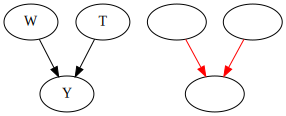

In [12]:
g = gr.Digraph()

g.edge("W", "Y"), g.edge("T", "Y")

g.edge("智力", "工资", color="red"), g.edge("教育", "工资", color="red")

g

另一方面，回归是通过比较 \\(T\\) 的效果同时将混杂因素 \\(W\\) 设置为固定水平来实现的。 对于回归，W 不会停止引起 T 和 Y。只是它保持固定，所以它不能影响 T 和 Y 的变化。

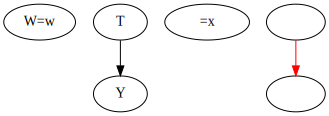

In [13]:
g = gr.Digraph()

g.node("W=w"), g.edge("T", "Y")
g.node("智力=x"), g.edge("教育", "工资", color="red")

g

现在，回到我们的问题，我们估计的参数是“edu”对工资因果关系的影响吗？我很抱歉把它带给你，但这将取决于我们是否有能力争论支持或反对所有混杂因素都已包含在模型中的事实。就个人而言，我认为他们没有。例如，我们没有包括家庭财富。即使我们包括家庭教育，也只能被视为财富的代表。我们也没有考虑个人野心等因素。可能是雄心壮志导致了更多的教育年限和更高的工资，所以它是一个混杂因素。这是为了表明**对非随机或观察数据的因果推断应该始终持保留态度**。我们永远无法确定所有的混杂因素都被考虑在内。

## 关键思想

本章里面，我们已经覆盖了回归的很多知识。我们看到了回归如何用于执行 A/B 测试以及它如何方便地为我们提供置信区间。然后，我们开始研究回归如何解决预测问题，它是 CEF 的最佳线性近似。我们还讨论了在双变量情况下，干预变量的回归系数等于干预和结果之间的协方差除以干预的方差。扩展到多变量的情况后，我们发现回归如何为我们提供对干预因子在排除其他因素影响后的边际解释：干预因子系数的估计值可以解释为在保持所有其他包含的变量不变的情况下，结果如何随着干预而变化。这就是经济学家喜欢称之为*ceteris paribus* 的东西。

最后，我们开始转向研究偏差。我们看到了“Short 等于 long 加上省略乘以省略对包含的回归的影响”。这揭示了偏差是如何产生的。我们发现导致遗漏变量偏差的来源就是混淆因子：一个同时影响干预和结果的变量。最后，我们使用因果图来了解 RCT 和回归如何解决混淆。